# Create test data subset of OAE dataset for CarbonPlan

03/10/2024

Tom Nicholas

Notebook to create store1b in it's entirety for CarbonPlan.

We need to deal with a lot of data, but the problem is embarrassingly parallel (for each polygon).

The plan is to create one function that reads the relevant part of the netCDF dataset, does the effficiency calculation, then saves out to just one region of a new zarr store. Then this function can be parallelized using `dask.delayed`, until the whole job is done.

Variables that do not depend on `polygon_id` will need to be written in a separate `to_zarr` call once.

## Define task for each polygon

We eventually need a function which:
1. Accepts a polygon id as an input,
2. Opens all the netCDF files corresponding to that polygon into xarray
3. Combines the datasets into one
4. Does whatever OAE efficiency calculation etc.
6. Writes the result into the correct `region` of a zarr store

Let's build these one-by-one and call them in one function at the end

In [1]:
store1b_path = '/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/CarbonPlan/perlmutter/store1b.zarr'

### 1-3 (opening and combining)

In [2]:
from typing import List
import datetime
import re
import glob

import cftime
import xarray as xr
import numpy as np
import dask

In [3]:
# these are the only variables we actually need to calculate OAE efficiency
REQUIRED_DATA_VARIABLES = [
    'DIC',
    'DIC_ALT_CO2',
    'ALK',
    'ALK_ALT_CO2',
    # For vertical integration
    'dz',
    'TAREA',
    # dimension coords
    'polygon_id',
    'elapsed_time',
    'injection_month',
    'ULONG',
    'ULAT',
]

In [4]:
data_dir = '/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/ResearchGrade/compressed4/'

In [5]:
polygon_id = '000'
injection_month = '01'
single_simulation_glob = data_dir + f'{polygon_id}/{injection_month}/alk-forcing.{polygon_id}-1999-{injection_month}.pop.h.*.nc'
single_simulation_glob

'/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/ResearchGrade/compressed4/000/01/alk-forcing.000-1999-01.pop.h.*.nc'

In [6]:
%%time
single_simulation = xr.open_mfdataset(
    single_simulation_glob,
    combine='by_coords', # can we do this with combine='nested'?
    data_vars='minimal',
    coords='minimal',
    compat='override',
    chunks={'time': 12, 'z_t': 60, 'nlat': 384, 'nlon': 320},  # open same way files are split (why does this not happen automatically??)
)

CPU times: user 16.6 s, sys: 2.89 s, total: 19.5 s
Wall time: 3min 4s


In [7]:
single_simulation

<xarray.Dataset> Size: 55GB
Dimensions:                     (injection_date: 1, elapsed_time: 180, d2: 2,
                                 z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                                 z_w_bot: 60, nlat: 384, nlon: 320,
                                 polygon_id: 1)
Coordinates: (12/64)
    time_bound                  (injection_date, elapsed_time, d2) object 3kB dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    time                        (injection_date, elapsed_time) object 1kB dask.array<chunksize=(1, 1), meta=np.ndarray>
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * polygon_id                  (polygon_id) int64 8B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
  * elapsed_time                (elapsed_time) timedelta64[ns] 1kB 0 days ......
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/34)
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    co3_sat_calc                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    co3_sat_arag                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    ...                          ...
    ALK_ALT_CO2_zint_100m       (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    STF_ALK_ALT_CO2             (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_DIC          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_DIC_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_ALK          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_ALK_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
Attributes:
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

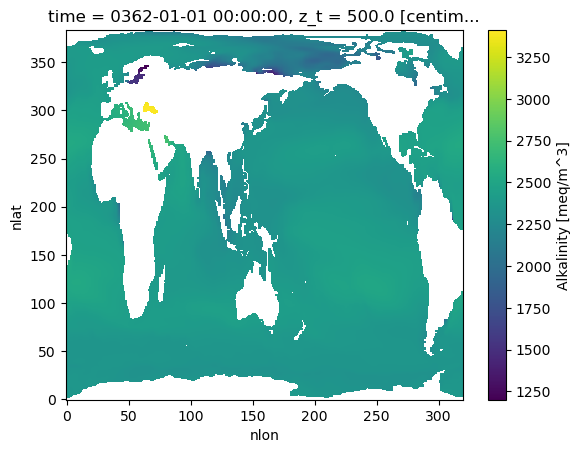

In [8]:
single_simulation['ALK'].isel(z_t=0, elapsed_time=-1).plot()

In [9]:
VARS_TO_DROP = [var_name for var_name in list(single_simulation.variables) if var_name not in REQUIRED_DATA_VARIABLES]

In [10]:
VARS_TO_DROP

['time_bound',
 'time',
 'z_t',
 'z_t_150m',
 'z_w',
 'z_w_top',
 'z_w_bot',
 'dzw',
 'TLONG',
 'TLAT',
 'KMT',
 'KMU',
 'REGION_MASK',
 'UAREA',
 'HU',
 'HT',
 'DXU',
 'DYU',
 'DXT',
 'DYT',
 'HTN',
 'HTE',
 'HUS',
 'HUW',
 'ANGLE',
 'ANGLET',
 'days_in_norm_year',
 'grav',
 'omega',
 'radius',
 'cp_sw',
 'sound',
 'vonkar',
 'cp_air',
 'rho_air',
 'rho_sw',
 'rho_fw',
 'stefan_boltzmann',
 'latent_heat_vapor',
 'latent_heat_fusion',
 'latent_heat_fusion_mks',
 'ocn_ref_salinity',
 'sea_ice_salinity',
 'T0_Kelvin',
 'salt_to_ppt',
 'ppt_to_salt',
 'mass_to_Sv',
 'heat_to_PW',
 'salt_to_Svppt',
 'salt_to_mmday',
 'momentum_factor',
 'hflux_factor',
 'fwflux_factor',
 'salinity_factor',
 'sflux_factor',
 'nsurface_t',
 'nsurface_u',
 'CO3',
 'pH_3D',
 'CO3_ALT_CO2',
 'pH_3D_ALT_CO2',
 'co3_sat_calc',
 'co3_sat_arag',
 'CO2STAR',
 'DCO2STAR',
 'pCO2SURF',
 'DpCO2',
 'FG_CO2',
 'PH',
 'ATM_CO2',
 'CO2STAR_ALT_CO2',
 'DCO2STAR_ALT_CO2',
 'pCO2SURF_ALT_CO2',
 'DpCO2_ALT_CO2',
 'FG_ALT_CO2',

In [11]:
def open_data_for_one_simulation(polygon_id: str, injection_month: str) -> xr.Dataset:

    ds = xr.open_mfdataset(
        data_dir + f'{polygon_id}/{injection_month}/alk-forcing.{polygon_id}-1999-{injection_month}.pop.h.*.nc',
        #preprocess=add_injection_time_coord,
        combine='by_coords', # can we do this with combine='nested'?
        drop_variables=VARS_TO_DROP,
        data_vars='minimal',
        coords='minimal',
        compat='override',
        join='override',
        chunks={'time': 12, 'z_t': 60, 'nlat': 384, 'nlon': 320},  # open same way files are split (why does this not happen automatically??)
    )

    elapsed_time_integer_months = xr.DataArray(np.arange(180), dims=['elapsed_time'], attrs={'units': 'months'})
    ds['elapsed_time'] = elapsed_time_integer_months.astype('int32')

    ds['injection_date'] = xr.DataArray(data=[int(injection_month)], dims='injection_date', attrs={'units': 'month of 1999'}).astype('int32')

    ds['polygon_id'] = ds['polygon_id'].astype('int32')
    
    #return ds.swap_dims(time='elapsed_time')
    return ds

In [12]:
%%time
ds0 = open_data_for_one_simulation('000', '01')

CPU times: user 7.22 s, sys: 571 ms, total: 7.79 s
Wall time: 8.06 s


In [13]:
ds0

<xarray.Dataset> Size: 21GB
Dimensions:         (z_t: 60, nlat: 384, nlon: 320, polygon_id: 1,
                     injection_date: 1, elapsed_time: 180)
Coordinates:
    dz              (z_t) float32 240B dask.array<chunksize=(60,), meta=np.ndarray>
    TAREA           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * polygon_id      (polygon_id) int32 4B 0
  * elapsed_time    (elapsed_time) int32 720B 0 1 2 3 4 ... 175 176 177 178 179
  * injection_date  (injection_date) int32 4B 1
Dimensions without coordinates: z_t, nlat, nlon
Data variables:
    ULONG           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DIC             (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    DIC_ALT_CO2     (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    ALK             (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    ALK_ALT_CO2     (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### 4 (OAE efficiency calculation)

In [14]:
def integrate_globally(var: xr.DataArray, volume_element) -> xr.DataArray:
    """Integrate a 3D variable globally over all spatial dimensions"""
    # from https://github.com/CWorthy-ocean/oae-dor-global-efficiency/blob/main/notebooks/demo-analysis-C-inventory.ipynb
    return (var * volume_element).sum(['z_t', 'nlat', 'nlon'])

In [15]:
def calc_oae_efficiency(ds: xr.Dataset) -> xr.Dataset:
    # where does the 1e-9 come from? presumably some density units conversion?
    volume_element = ds['dz'] * ds['TAREA'] * 1e-9

    delta_DIC = integrate_globally(ds['DIC'] - ds['DIC_ALT_CO2'], volume_element)
    delta_ALK = integrate_globally(ds['ALK'] - ds['ALK_ALT_CO2'], volume_element)
    OAE_efficiency = delta_DIC / delta_ALK  # this will still be a function of time

    ds['OAE_efficiency'] = OAE_efficiency.astype('float32')

    return ds

### 5 (write into target store)

In [16]:
store1b_chunks_encoding_per_variable = {
    'OAE_efficiency':  {'chunks': {'polygon_id': 1, 'injection_date': 1, 'elapsed_time': 180}},          # polygon_id: 1 injection_date: 1 elapsed_time: 180
    #'ALK_zint_100m':   {'chunks': (1, 384, 320)},        # polygon_id: 1 nlat: 384 nlon: 320
    'polygon_id':      {'chunks': {'polygon_id': 690}},                 # polygon_id: 1
    'injection_date':  {'chunks': {'injection_date': 1}},                 # injection_date: 1
    'elapsed_time':    {'chunks': {'elapsed_time': 180}},               # elapsed_time: 180
    #'time':            {'chunks': (1, 180)},             # injection_date: 1 elapsed_time: 180
}

In [17]:
def add_compression_encoding(ds: xr.Dataset) -> xr.Dataset:
    import zarr

    compressor = zarr.Zlib(level=1)
    
    for name in list(ds.variables):
        ds[name].encoding['compressor'] = compressor

    return ds

### all together

In [18]:
@dask.delayed
def process_polygon(polygon_id: str, injection_date: str) -> dask.delayed:
    ds = open_data_for_one_simulation(polygon_id, injection_date)

    ds = calc_oae_efficiency(ds)

    ds_to_save_computed = ds[['OAE_efficiency']].compute()

    ds_with_compression_encoding = add_compression_encoding(ds_to_save_computed)
    
    #return ds
    return ds_to_save_computed.to_zarr(store=store1b_path, region='auto')

## Define structure of target store

We need to create a zarr store with empty arrays for the outputs we want to write in sequentially later.

In [50]:
non_ensemble_ds = ds0.isel(z_t=0).drop_dims(['polygon_id', 'injection_date']).coords.to_dataset()
#non_ensemble_ds = ds0.isel(z_t=0).coords.to_dataset()

In [51]:
non_ensemble_ds

<xarray.Dataset> Size: 984kB
Dimensions:       (nlat: 384, nlon: 320, elapsed_time: 180)
Coordinates:
    dz            float32 4B dask.array<chunksize=(), meta=np.ndarray>
    TAREA         (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * elapsed_time  (elapsed_time) int32 720B 0 1 2 3 4 5 ... 175 176 177 178 179
Dimensions without coordinates: nlat, nlon
Data variables:
    *empty*
Attributes:
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [52]:
non_ensemble_vars_plus_ensemble_dim_coords = non_ensemble_ds.copy()

In [53]:
# coordinates are loaded into memory so let's just create them complete already for ensemble dims
non_ensemble_vars_plus_ensemble_dim_coords['polygon_id'] = xr.DataArray(np.arange(690), dims='polygon_id').astype('int32')
non_ensemble_vars_plus_ensemble_dim_coords['injection_date'] = xr.DataArray([1, 4, 7, 10], dims='injection_date').astype('int32')

In [54]:
non_ensemble_vars_plus_ensemble_dim_coords

<xarray.Dataset> Size: 987kB
Dimensions:         (nlat: 384, nlon: 320, elapsed_time: 180, polygon_id: 690,
                     injection_date: 4)
Coordinates:
    dz              float32 4B dask.array<chunksize=(), meta=np.ndarray>
    TAREA           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * elapsed_time    (elapsed_time) int32 720B 0 1 2 3 4 ... 175 176 177 178 179
  * polygon_id      (polygon_id) int32 3kB 0 1 2 3 4 5 ... 685 686 687 688 689
  * injection_date  (injection_date) int32 16B 1 4 7 10
Dimensions without coordinates: nlat, nlon
Data variables:
    *empty*
Attributes:
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### Write non-ensemble variables

Includes polygon_mask_id

In [55]:
add_compression_encoding(non_ensemble_vars_plus_ensemble_dim_coords).to_zarr(store=store1b_path, mode='w', compute=True)

In [56]:
store1b_path

'/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/CarbonPlan/perlmutter/store1b.zarr'

In [57]:
!ls /glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/CarbonPlan/perlmutter/store1b.zarr

dz  elapsed_time  injection_date  polygon_id  TAREA


### Write empty placeholders for ensemble variables

now add empty versions of the ensemble variables

In [58]:
import dask.array as dsa


sizes_all_dims = {
    'elapsed_time': 180, 
    'polygon_id': 690, 
    'injection_date': 4,
}

def create_empty_target_variable(var_name: str, dtype) -> xr.DataArray:
    var_chunks = store1b_chunks_encoding_per_variable[var_name]['chunks']
    var_dims = list(var_chunks.keys())
    var_sizes = {d: s for d, s in sizes_all_dims.items() if d in var_dims}
    var_shape = tuple(var_sizes.values())
    ordered_var_dims = list(var_sizes.keys())
    
    da_target = xr.DataArray(
        dsa.empty(
            shape=var_shape,
            chunks=var_chunks,
            dtype=dtype,
        ),
        name=var_name,
        dims=ordered_var_dims,
    )
    return da_target.chunk(**var_chunks)

In [59]:
target_ds = non_ensemble_vars_plus_ensemble_dim_coords.copy()

# placeholder dask array for OAE_efficiency
new_empty_var = create_empty_target_variable('OAE_efficiency', "f8")
target_ds['OAE_efficiency'] = new_empty_var

In [60]:
target_ds

<xarray.Dataset> Size: 5MB
Dimensions:         (nlat: 384, nlon: 320, elapsed_time: 180, polygon_id: 690,
                     injection_date: 4)
Coordinates:
    dz              float32 4B dask.array<chunksize=(), meta=np.ndarray>
    TAREA           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * elapsed_time    (elapsed_time) int32 720B 0 1 2 3 4 ... 175 176 177 178 179
  * polygon_id      (polygon_id) int32 3kB 0 1 2 3 4 5 ... 685 686 687 688 689
  * injection_date  (injection_date) int32 16B 1 4 7 10
Dimensions without coordinates: nlat, nlon
Data variables:
    OAE_efficiency  (elapsed_time, polygon_id, injection_date) float64 4MB dask.array<chunksize=(180, 1, 1), meta=np.ndarray>
Attributes:
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [61]:
add_compression_encoding(target_ds).to_zarr(store=store1b_path, mode='w', compute=False)

Delayed('_finalize_store-854a91fa-55a0-4303-876a-c7e13313532f')

In [62]:
!ls /glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/CarbonPlan/perlmutter/store1b.zarr

dz  elapsed_time  injection_date  OAE_efficiency  polygon_id  TAREA


## Perform tasks for all polygons

In [52]:
ds = open_data_for_one_simulation('000', '01')

In [53]:
ds = calc_oae_efficiency(ds)

In [54]:
ds_to_save = ds[['OAE_efficiency']]

In [55]:
ds_to_save['OAE_efficiency']

<xarray.DataArray 'OAE_efficiency' (polygon_id: 1, injection_date: 1,
                                    elapsed_time: 180)> Size: 720B
dask.array<astype, shape=(1, 1, 180), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * polygon_id      (polygon_id) int32 4B 0
  * elapsed_time    (elapsed_time) int32 720B 0 1 2 3 4 ... 175 176 177 178 179
  * injection_date  (injection_date) int32 4B 1

In [56]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [57]:
%%time
ds_to_save_computed = ds_to_save.compute()

[########################################] | 100% Completed | 155.79 s
CPU times: user 1min 39s, sys: 19.1 s, total: 1min 58s
Wall time: 2min 35s


In [58]:
ds_to_save_computed

<xarray.Dataset> Size: 1kB
Dimensions:         (polygon_id: 1, injection_date: 1, elapsed_time: 180)
Coordinates:
  * polygon_id      (polygon_id) int32 4B 0
  * elapsed_time    (elapsed_time) int32 720B 0 1 2 3 4 ... 175 176 177 178 179
  * injection_date  (injection_date) int32 4B 1
Data variables:
    OAE_efficiency  (polygon_id, injection_date, elapsed_time) float32 720B 0...
Attributes:
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [59]:
add_compression_encoding(ds_to_save_computed).to_zarr(store=store1b_path, region='auto')

In [76]:
import xarray as xr

In [80]:
roundtrip = xr.open_zarr(store=store1b_rechunked_path)

In [81]:
roundtrip

<xarray.Dataset> Size: 3MB
Dimensions:         (elapsed_time: 180, polygon_id: 690, injection_date: 4,
                     nlat: 384, nlon: 320)
Coordinates:
    TAREA           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz              float32 4B ...
  * elapsed_time    (elapsed_time) float64 1kB 0.0 1.0 2.0 ... 177.0 178.0 179.0
  * injection_date  (injection_date) float64 32B 1.0 4.0 7.0 10.0
  * polygon_id      (polygon_id) float64 6kB 0.0 1.0 2.0 ... 687.0 688.0 689.0
Dimensions without coordinates: nlat, nlon
Data variables:
    OAE_efficiency  (elapsed_time, polygon_id, injection_date) float32 2MB dask.array<chunksize=(180, 690, 1), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    history:           none
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    time_period_freq:  month_1
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...

In [82]:
roundtrip['OAE_efficiency']

<xarray.DataArray 'OAE_efficiency' (elapsed_time: 180, polygon_id: 690,
                                    injection_date: 4)> Size: 2MB
dask.array<open_dataset-OAE_efficiency, shape=(180, 690, 4), dtype=float32, chunksize=(180, 690, 1), chunktype=numpy.ndarray>
Coordinates:
    dz              float32 4B ...
  * elapsed_time    (elapsed_time) float64 1kB 0.0 1.0 2.0 ... 177.0 178.0 179.0
  * injection_date  (injection_date) float64 32B 1.0 4.0 7.0 10.0
  * polygon_id      (polygon_id) float64 6kB 0.0 1.0 2.0 ... 687.0 688.0 689.0

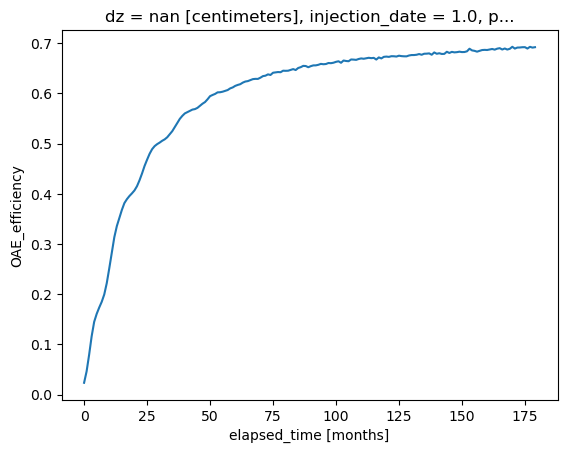

In [84]:
roundtrip['OAE_efficiency'].isel(polygon_id=100, injection_date=0).plot()

In [63]:
roundtrip.close()

Looks good, so let's do all the rest.

### Set up all OAE efficiency calculations

In [19]:
def polygon_ids_as_strings(s: slice) -> list[str]:
    """Generate list of all polygon ids of the form '001' in this slice."""
    values = np.arange(s.start, s.stop)

    def left_pad_with_zeros(number, width):
        return f"{number:0{width}}"
        
    return [left_pad_with_zeros(val, 3) for val in values]

In [20]:
690 * 4

2760

In [21]:
polygon_ids_as_strings(slice(0, 690))

['000',
 '001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',


In [22]:
all_tasks = [
    process_polygon(polygon_id, injection_month)
    for polygon_id in polygon_ids_as_strings(slice(0, 690))
    for injection_month in ['01', '04', '07', '10']
]

In [23]:
len(all_tasks)

2760

In [24]:
all_tasks[0:10]

[Delayed('process_polygon-0a0f9d52-131f-4ecf-b670-60579617f1b1'),
 Delayed('process_polygon-8c20f988-2add-4bf5-8f20-8a691a261574'),
 Delayed('process_polygon-5335bb6e-5962-4237-a244-3a9acc983618'),
 Delayed('process_polygon-d8832d87-c316-4b0f-9141-db5b65d1fa52'),
 Delayed('process_polygon-ced32a65-beaa-4981-94cf-a09cefab4bcf'),
 Delayed('process_polygon-daf75210-23e2-4f89-8a66-bf9af82da1a0'),
 Delayed('process_polygon-6c0a289a-3c78-43b0-b576-b19a088cfcd8'),
 Delayed('process_polygon-53344e28-c19f-4d6d-a556-cba1aba9136d'),
 Delayed('process_polygon-f310c331-c7fc-417c-b73e-a6b6d942c2b0'),
 Delayed('process_polygon-df88b97f-fad3-4fe3-a2b1-62f2d873232c')]

### Scale up

In [25]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [26]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'carbonplan-store1b',
    cores = 1,
    memory = '25GiB',
    processes = 1,
    local_directory = '/local_scratch/pbs.$PBS_JOBID/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=25GB',
    queue = 'casper',
    walltime = '24:00:00',
    interface = 'ext',
    job_extra_directives=['-V'],
)

/glade/work/tnicholas/conda-envs/kerchunk3.9/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34269 instead
  warnings.warn(


In [27]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/34269/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.103:41147,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/34269/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [28]:
# Create the client to load the Dashboard
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/34269/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/34269/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.103:41147,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/34269/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [29]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N carbonplan-store1b
#PBS -q casper
#PBS -A P93300670
#PBS -l select=1:ncpus=1:mem=25GB
#PBS -l walltime=24:00:00
#PBS -V

/glade/work/tnicholas/conda-envs/kerchunk3.9/bin/python -m distributed.cli.dask_worker tcp://128.117.208.103:41147 --name dummy-name --nthreads 1 --memory-limit 25.00GiB --nanny --death-timeout 60 --local-directory /local_scratch/pbs.$PBS_JOBID/dask/spill --interface ext



In [30]:
cluster.scale(150)

In [44]:
len(all_tasks)

2760

In [75]:
dask.persist(all_tasks[:1500], retries=1)

([Delayed('process_polygon-c25d0990-2361-4bf2-b12c-1273653d3e16'),
  Delayed('process_polygon-c4ab363b-8661-4997-a38b-7726ffde374e'),
  Delayed('process_polygon-aed81bda-dc54-4ea2-93c6-0072e2dc3c8f'),
  Delayed('process_polygon-f5b44879-6a3c-48cb-a775-0af2057cc929'),
  Delayed('process_polygon-eb6538bf-6b4c-4c88-b309-60bdbbfdf45f'),
  Delayed('process_polygon-b2202409-3649-4a5e-b1b5-c458a75d81e1'),
  Delayed('process_polygon-c0c0da70-13e8-4b48-b1cf-b661d040437c'),
  Delayed('process_polygon-de2d79d1-b9d4-4165-80d5-35ccdf263e67'),
  Delayed('process_polygon-0b653cff-3cc3-400f-bca9-a83de9daddb9'),
  Delayed('process_polygon-6756a251-1bff-48cf-b364-6312f1dacb2e'),
  Delayed('process_polygon-2b064c9b-c142-4fd9-8bb7-83f9104d753b'),
  Delayed('process_polygon-e1706b6b-9b29-4298-a42d-27ddede8ca53'),
  Delayed('process_polygon-9adf2004-16a2-4cc0-952a-99c6a7a8eb8e'),
  Delayed('process_polygon-50d7a058-7095-4c38-9859-0721d70c30f9'),
  Delayed('process_polygon-637c867e-b237-4a56-b706-34558c78a2b

submitted 1500 tasks on 142 25GB workers at 2:07pm

In [31]:
dask.persist(all_tasks[1500:], retries=1)

([Delayed('process_polygon-c43217a2-b3a0-4e7a-b187-80c6288737f6'),
  Delayed('process_polygon-532c1fb5-7593-4abb-99f8-34dc29aafba6'),
  Delayed('process_polygon-95678441-d6b1-4e7c-860b-bbc1eff5a4de'),
  Delayed('process_polygon-421bc87c-60fe-48a2-89ba-30f03b12877f'),
  Delayed('process_polygon-478c7d2b-39d7-4c3f-8845-725ea0e62a23'),
  Delayed('process_polygon-f2227b84-11ca-4ce0-b085-33d56a18b8bb'),
  Delayed('process_polygon-16631ee2-0890-4036-8c2d-ab24b33803dc'),
  Delayed('process_polygon-58f73779-3712-4a12-b31a-f753313635eb'),
  Delayed('process_polygon-04caaeb6-c34c-4b48-8c9c-42a8b6545ae3'),
  Delayed('process_polygon-4d1e8f4a-8e60-4736-8217-97e9c13db1d4'),
  Delayed('process_polygon-3b2db3ce-68fd-428d-8705-0566a76837cf'),
  Delayed('process_polygon-4c44ea1f-efa4-4c5f-a66f-0cf227e712e2'),
  Delayed('process_polygon-48aa119d-9eb3-4918-8354-805cafb38b55'),
  Delayed('process_polygon-9ad5127a-dc60-403f-aeb7-1f30f2d068e8'),
  Delayed('process_polygon-1480c720-bb9c-4bc5-846e-9a29e49d08c

submitted (2760-1500) tasks on 142 25GB workers at 9:57pm

In [45]:
cluster.scale(300)

In [73]:
cluster.scale(0)

In [74]:
cluster.close()

In [75]:
client.close()

### rechunk

Should have made sure each polygon was not a separate chunk

In [60]:
import xarray as xr

In [61]:
wrong_chunks = xr.open_zarr(store1b_path)

In [62]:
wrong_chunks

<xarray.Dataset> Size: 5MB
Dimensions:         (elapsed_time: 180, polygon_id: 690, injection_date: 4,
                     nlat: 384, nlon: 320)
Coordinates:
    TAREA           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz              float32 4B ...
  * elapsed_time    (elapsed_time) int32 720B 0 1 2 3 4 ... 175 176 177 178 179
  * injection_date  (injection_date) int32 16B 1 4 7 10
  * polygon_id      (polygon_id) int32 3kB 0 1 2 3 4 5 ... 685 686 687 688 689
Dimensions without coordinates: nlat, nlon
Data variables:
    OAE_efficiency  (elapsed_time, polygon_id, injection_date) float64 4MB dask.array<chunksize=(180, 1, 1), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    history:           none
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    time_period_freq:  month_1
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...

In [63]:
correct_chunks = wrong_chunks.chunk(
    polygon_id=690,
)

In [64]:
correct_chunks

<xarray.Dataset> Size: 5MB
Dimensions:         (elapsed_time: 180, polygon_id: 690, injection_date: 4,
                     nlat: 384, nlon: 320)
Coordinates:
    TAREA           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz              float32 4B ...
  * elapsed_time    (elapsed_time) int32 720B 0 1 2 3 4 ... 175 176 177 178 179
  * injection_date  (injection_date) int32 16B 1 4 7 10
  * polygon_id      (polygon_id) int32 3kB 0 1 2 3 4 5 ... 685 686 687 688 689
Dimensions without coordinates: nlat, nlon
Data variables:
    OAE_efficiency  (elapsed_time, polygon_id, injection_date) float64 4MB dask.array<chunksize=(180, 690, 1), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    history:           none
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    time_period_freq:  month_1
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...

In [65]:
correct_chunks['OAE_efficiency'] = correct_chunks['OAE_efficiency'].astype(np.dtype('float32'))

In [66]:
def set_compression_encoding(ds: xr.Dataset) -> xr.Dataset:
    from zarr import Zlib

    compressor = Zlib(level=1)
    
    for name, var in ds.variables.items():
            
        # avoid using NaN as a fill value, and avoid overflow errors in encoding
        if np.issubdtype(var.dtype, np.integer):
            ds[name].encoding = {'compressor': compressor, '_FillValue': 2_147_483_647}
        elif var.dtype == np.dtype('float32'):
            ds[name].encoding = {'compressor': compressor, '_FillValue': 9.969209968386869e+36}
        else:
            ds[name].encoding = {'compressor': compressor}

    return ds

In [67]:
correct_chunks = set_compression_encoding(correct_chunks)

In [68]:
correct_chunks['OAE_efficiency'].encoding['chunks'] = (180, 690, 1)

In [69]:
correct_chunks['OAE_efficiency'].encoding

{'compressor': Zlib(level=1),
 '_FillValue': 9.969209968386869e+36,
 'chunks': (180, 690, 1)}

In [70]:
correct_chunks

<xarray.Dataset> Size: 3MB
Dimensions:         (elapsed_time: 180, polygon_id: 690, injection_date: 4,
                     nlat: 384, nlon: 320)
Coordinates:
    TAREA           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz              float32 4B ...
  * elapsed_time    (elapsed_time) int32 720B 0 1 2 3 4 ... 175 176 177 178 179
  * injection_date  (injection_date) int32 16B 1 4 7 10
  * polygon_id      (polygon_id) int32 3kB 0 1 2 3 4 5 ... 685 686 687 688 689
Dimensions without coordinates: nlat, nlon
Data variables:
    OAE_efficiency  (elapsed_time, polygon_id, injection_date) float32 2MB dask.array<chunksize=(180, 690, 1), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    history:           none
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    time_period_freq:  month_1
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...

In [71]:
store1b_rechunked_path = '/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/CarbonPlan/perlmutter/store1b_rechunked.zarr'

In [72]:
correct_chunks.to_zarr(store1b_rechunked_path)